---
title: Part 1. GRASS GIS 101
description: Learn the basics of GRASS GIS, a powerful open-source geospatial procesing engine.
format:
    html:
        code-fold: false
author: 
    - Corey T. White
    - Vaclav Petras
date: '2024-09-10'
keep-ipynb: true
toc: true
toc-depth: 4
image:  images/webinar_title.webp
categories: [geospatial, GRASS v8.5, jupyter, lidar, STAC]
page-layout: full
title-block-banner: true
---

# GRASS GIS 101

This notebook is a quick introduction to GRASS and Jupyter Notebooks.

By default all cells are running Python:

In [2]:
import sys
v = sys.version_info
print(f"We are using Python {v.major}.{v.minor}.{v.micro}")

We are using Python 3.10.12


But you can also run shell commands by prefixing them with `!` or use `%%bash` to run the whole cell as a shell script.

In [102]:
# !sudo apt-get install figlet

!figlet "GRASS GIS 101"

  ____ ____      _    ____ ____     ____ ___ ____    _  ___  _ 
 / ___|  _ \    / \  / ___/ ___|   / ___|_ _/ ___|  / |/ _ \/ |
| |  _| |_) |  / _ \ \___ \___ \  | |  _ | |\___ \  | | | | | |
| |_| |  _ <  / ___ \ ___) |__) | | |_| || | ___) | | | |_| | |
 \____|_| \_\/_/   \_\____/____/   \____|___|____/  |_|\___/|_|
                                                               


In [103]:
%%bash
grass -v

GRASS GIS 8.3.1
Geographic Resources Analysis Support System (GRASS) is Copyright,
1999-2023 by the GRASS Development Team, and licensed under terms of the
GNU General Public License (GPL) version >=2.

This GRASS GIS 8.3.1 release is coordinated and produced by
the GRASS Development Team with contributions from all over the world.

This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
General Public License for more details.


## GRASS Project Setup

In [236]:
# import standard Python packages
import os
import subprocess
import json
from io import StringIO
from pathlib import Path
from IPython.display import IFrame
from pandas import DataFrame

## Setup GRASS environment

In [4]:
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)


In [38]:
# import GRASS GIS python packages
%reload_ext autoreload
%autoreload 2
import grass.script as gs
import grass.jupyter as gj

In [6]:
# create a temporary folder where to place our GRASS project
import tempfile
tempdir = tempfile.TemporaryDirectory()

## Create a new GRASS project

In [7]:
gs.create_project(path=tempdir.name, name="foss4g2024", epsg="2817", overwrite=True)

In [8]:
# start GRASS in the recently created project
session = gj.init(Path(tempdir.name,"foss4g2024"))

In [ ]:
# !ogrinfo "/vsizip//vsicurl/https://www.stlouis-mo.gov/data/upload/data-files/stl_boundary.zip" -al
# !ogrinfo /vsizip//vsicurl/https://www.stlouis-mo.gov/data/upload/data-files/streets.zip -al
# !ogrinfo /vsizip/vsicurl/https://static.stlouis-mo.gov/open-data/planning/neighborhoods/neighborhoods.zip/Neighborhoods -al

### Import Vector data

Let's import some vector data from the city of St. Louis' open data portal.

[https://www.stlouis-mo.gov/data/datasets/index.cfm](https://www.stlouis-mo.gov/data/datasets/index.cfm)


#### City Boundary

In [9]:
gs.run_command("v.import",
   input="/vsizip//vsicurl/https://www.stlouis-mo.gov/data/upload/data-files/stl_boundary.zip",
   output="stl_boundary",
   layer="stl_boundary",
   snap=0.0001,
   # epsg=8801
)

#### Streets

In [133]:
streets_url="/vsizip//vsicurl/https://www.stlouis-mo.gov/data/upload/data-files/streets.zip"

gs.run_command("v.import",
   input=streets_url,
   output="stl_streets",
   layer="TgrGeoCd",
   snap=0.0001,
   # epsg=8801
)

#### Neighborhoods

In [166]:
neigh_url="/vsizip/vsicurl/https://static.stlouis-mo.gov/open-data/planning/neighborhoods/neighborhoods.zip/Neighborhoods"
gs.run_command("v.import",
   input=streets_url,
   output="stl_neighborhoods",
   layer="TgrGeoCd",
   snap=0.0001,
   # epsg=8801 # Automatically reprojects to the project's EPSG
)

### Visualize data

#### Folium Web Map

In [186]:
map = gj.InteractiveMap(map_backend="folium")
map.add_vector("stl_boundary", fill_color="none", line_color="red")
# map.add_vector("stl_streets", line_color="grey")
map.add_layer_control()
map.show()

#### Map Figure

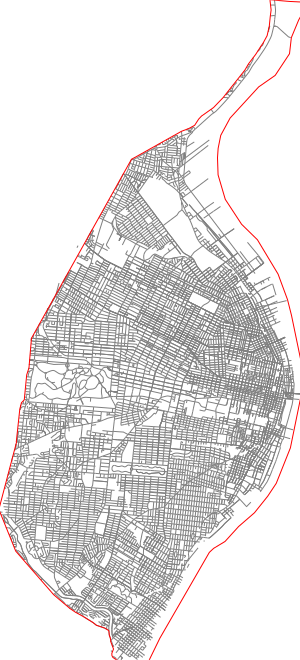

In [169]:
map = gj.Map(width=300)
map.d_vect(map="stl_streets", color="grey", fill_color="none")
# map.d_vect(map="stl_neighborhoods", color="blue", fill_color="none")
map.d_vect(map="stl_boundary", color="red", fill_color="none")
map.show()

### Import Raster Data

In [211]:
gs.run_command("g.region", vector="stl_boundary", res=30, flags="ap")

projection: 99 (NAD83(HARN) / Missouri West)
zone:       0
datum:      nad83harn
ellipsoid:  grs80
north:      298260
south:      271020
west:       1214160
east:       1226670
nsres:      30
ewres:      30
rows:       908
cols:       417
cells:      378636


#### Export STAC Catalog

https://stacindex.org/catalogs

In [190]:
gs.run_command("t.stac.catalog",
               url="https://earth-search.aws.element84.com/v1/",
               format="plain",
               flags="b")

---------------------------------------------------------------------------
Catalog: Earth Search by Element 84
---------------------------------------------------------------------------
Client Id: earth-search-aws
Client Description: A STAC API of public datasets on AWS
Client STAC Extensions: []
Client catalog_type: ABSOLUTE_PUBLISHED
---------------------------------------------------------------------------
Collections: 9
---------------------------------------------------------------------------
Collection Id | Collection Title
---------------------------------------------------------------------------
sentinel-2-pre-c1-l2a: Sentinel-2 Pre-Collection 1 Level-2A 
cop-dem-glo-30: Copernicus DEM GLO-30
naip: NAIP: National Agriculture Imagery Program
cop-dem-glo-90: Copernicus DEM GLO-90
landsat-c2-l2: Landsat Collection 2 Level-2
sentinel-2-l2a: Sentinel-2 Level-2A
sentinel-2-l1c: Sentinel-2 Level-1C
sentinel-2-c1-l2a: Sentinel-2 Collection 1 Level-2A
sentinel-1-grd: Sentinel-1 Lev

In [191]:
gs.run_command("t.stac.collection",
               url="https://earth-search.aws.element84.com/v1/",
               collection="cop-dem-glo-30",
               format="plain",
               flags="b"
            )

Collection ID: cop-dem-glo-30
STAC Version: 1.0.0
Description: The Copernicus DEM is a Digital Surface Model (DSM) which represents the surface of the Earth including buildings, infrastructure and vegetation. GLO-30 Public provides limited worldwide coverage at 30 meters because a small subset of tiles covering specific countries are not yet released to the public by the Copernicus Programme.
Extent: {'spatial': {'bbox': [[-180, -90, 180, 90]]}, 'temporal': {'interval': [['2021-04-22T00:00:00Z', '2021-04-22T00:00:00Z']]}}
License: proprietary
Keywords: ['Copernicus', 'DEM', 'DSM', 'Elevation']
---------------------------------------------------------------------------

Summary:
gsd: [30]
platform: ['tandem-x']
proj:epsg: [4326]
storage:platform: ['AWS']
storage:region: ['eu-central-1']
storage:requester_pays: [False]
---------------------------------------------------------------------------

Item Assets Keys: ['data']
-------------------------------------------------------------------

### Import Evelvation Data

The `t.stac.item` module will download the Copernicus DEM GLO-30 data from the STAC catalog.

In [14]:
gs.run_command("t.stac.item",
               url="https://earth-search.aws.element84.com/v1/",
               collection="cop-dem-glo-30",
               format="plain",
               extent="region",
               method="bicubic",
               resolution="value",
               memory="5000",
               resolution_value=30,
               flags="d"
            )

Import Url: /vsis3/copernicus-dem-30m/Copernicus_DSM_COG_10_N38_00_W091_00_DEM/Copernicus_DSM_COG_10_N38_00_W091_00_DEM.tif
Importing: cop-dem-glo-30.Copernicus_DSM_COG_10_N38_00_W091_00_DEM.data


In [235]:
gs.run_command("t.stac.item",
               url="https://earth-search.aws.element84.com/v1/",
               collection="naip",
               format="plain",
               extent="region",
               method="nearest",
               resolution="value",
               memory="5000",
               items_vector="naip",
               strds_output="outputs/naip",
               resolution_value=1,
               flags="d",
               nprocs=4
            )

Import Url: /vsis3/naip-analytic/mo/2022/60cm/rgbir_cog/38090/m_3809031_sw_15_060_20220618.tif
Importing: naip.mo_m_3809031_sw_15_060_20220618.image
Import Url: /vsis3/naip-analytic/mo/2022/60cm/rgbir_cog/38090/m_3809031_nw_15_060_20220618.tif
Importing: naip.mo_m_3809031_nw_15_060_20220618.image
Import Url: /vsis3/naip-analytic/mo/2022/60cm/rgbir_cog/38090/m_3809031_ne_15_060_20220618.tif
Importing: naip.mo_m_3809031_ne_15_060_20220618.image
Import Url: /vsis3/naip-analytic/mo/2022/60cm/rgbir_cog/38090/m_3809030_sw_15_060_20220618.tif
Importing: naip.mo_m_3809030_sw_15_060_20220618.image
Import Url: /vsis3/naip-analytic/mo/2022/60cm/rgbir_cog/38090/m_3809030_se_15_060_20220618.tif
Importing: naip.mo_m_3809030_se_15_060_20220618.image
Import Url: /vsis3/naip-analytic/mo/2022/60cm/rgbir_cog/38090/m_3809030_nw_15_060_20220618.tif
Importing: naip.mo_m_3809030_nw_15_060_20220618.image
Import Url: /vsis3/naip-analytic/mo/2022/60cm/rgbir_cog/38090/m_3809030_ne_15_060_20220618.tif
Importing: 

In [234]:
naip_json = gs.parse_command("v.db.select", map="naip", format="json")
df_naip = pd.DataFrame(naip_json["values"], columns=naip_json["columns"])

Downloads and imports data from a STAC API server.

Usage:
 t.stac.item [-miadp] url=string collection_id=string
   [request_method=string] [settings=name] [max_items=value] [limit=value]
   [ids=string] [bbox=value[,value,...]] [intersects=name]
   [datetime=value] [query=value] [filter=value]
   [asset_keys=string[,string,...]] [item_roles=string[,string,...]]
   [filter_lang=string] [sortby=value] [format=string] [strds_output=name]
   [items_vector=string] [method=string] [resolution=string]
   [resolution_value=value] [extent=string] [nprocs=value]
   [memory=memory in MB] [--overwrite] [--help] [--verbose] [--quiet]
   [--ui]

Flags:
  -m   Collection Search Item Summary
  -i   Item metadata
  -a   Asset metadata
  -d   Dowload and import assets
  -p   Pretty print the JSON output

Parameters:
               url   STAC API Client URL
     collection_id   Collection Id.
    request_method   The HTTP method to use when making a request to the service.
                     options: 

In [15]:
gs.run_command("g.rename", raster="cop-dem-glo-30.Copernicus_DSM_COG_10_N38_00_W091_00_DEM.data,cop-dem-glo-30")

In [40]:
map = gj.InteractiveMap(width=500, height=500, map_backend="ipyleaflet", use_region=True)
map.add_raster("cop-dem-glo-30")
map.add_vector("stl_boundary", fill_color="none", line_color="red")
map.add_layer_control()
map.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

projection: 99 (NAD83(HARN) / Missouri West)
zone:       0
datum:      nad83harn
ellipsoid:  grs80
north:      298260
south:      271020
west:       1214160
east:       1226670
nsres:      30
ewres:      30
rows:       908
cols:       417
cells:      378636


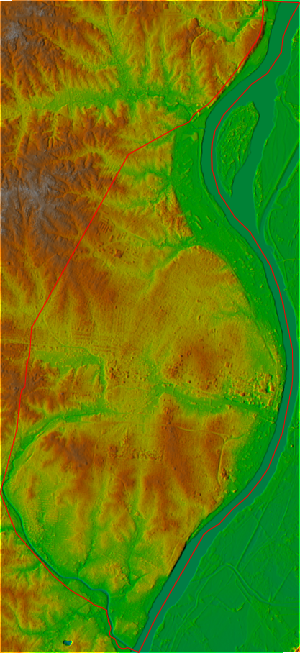

In [121]:
#| fig-cap: A map of the evelvation in the St. Louis area
#| layout: [1]

gs.run_command("g.region", raster="cop-dem-glo-30", res=30, flags="ap")
gs.run_command("r.colors", map="cop-dem-glo-30", color="elevation")
gs.run_command("r.relief", input="cjson.loads(naip_json.stdout)op-dem-glo-30", output="relief", overwrite=True)

map = gj.Map(width=300)
map.d_shade(shade="relief", color="cop-dem-glo-30")
map.d_vect(map="stl_boundary", color="red", fill_color="none")
map.show()

In [104]:
gs.run_command("r.slope.aspect", elevation="cop-dem-glo-30", slope="slope", aspect="aspect", overwrite=True)
gs.run_command("r.colors", map="slope", color="sepia", flags="e")

projection: 99 (NAD83(HARN) / Missouri West)
zone:       0
datum:      nad83harn
ellipsoid:  grs80
north:      298260
south:      271020
west:       1214160
east:       1226670
nsres:      30
ewres:      30
rows:       908
cols:       417
cells:      378636


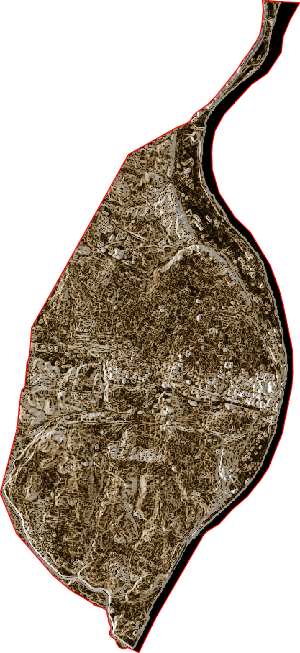

In [116]:
#| fig-cap: A map of the slope in the St. Louis area
#| layout: [1]

map = gj.Map(width=300)
map.d_shade(shade="relief", color="slope", brighten=30)
map.d_vect(map="stl_boundary", color="red", fill_color="none")
map.show()

### Distance to the nearest street

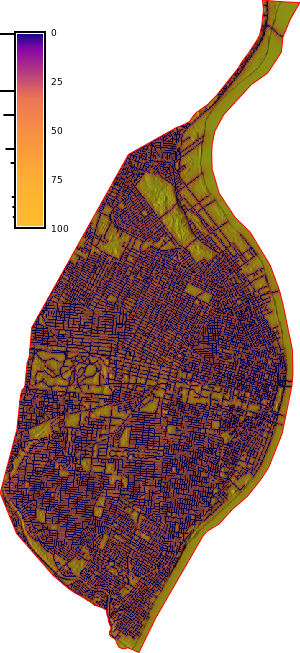

In [224]:
#| layout: [1,1]
gs.run_command("r.mask", vector="stl_boundary")
gs.run_command("v.to.rast", input="stl_streets", output="stl_streets", use="value", type="line", overwrite=True)
gs.run_command("r.grow.distance", input="stl_streets", distance="dist_to_road")
gs.run_command("r.colors", map="dist_to_road", color="plasma", flags="e")
map1 = gj.Map(width=300)
map1.d_shade(shade="relief", color="dist_to_road")
map1.d_vect(map="stl_boundary", color="red", fill_color="none")
map1.d_legend(raster="dist_to_road", at="95,65,5,15", range="0,100", flags="ds")
map1.show()


#### Road Density

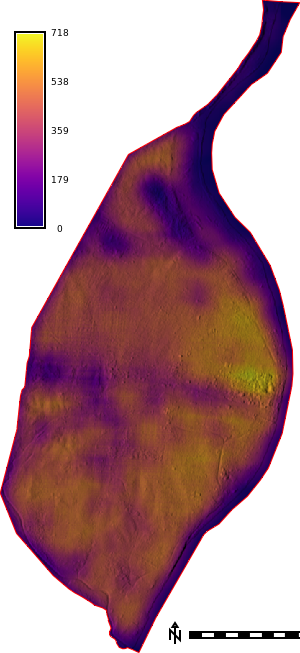

In [233]:
gs.run_command("r.neighbors", flags="", input="stl_streets", output="road_dens", size=37, method="count", memory=30000, nprocs=24)
gs.run_command("r.colors", map="road_dens", color="plasma", flags="")
map2 = gj.Map(width=300)
map2.d_shade(shade="relief", color="road_dens")
map2.d_vect(map="stl_boundary", color="red", fill_color="none")
map2.d_legend(raster="road_dens", at="95,65,5,15", flags="s")
map2.d_barscale(at="55,5,5,5", flags="n")
map2.show()

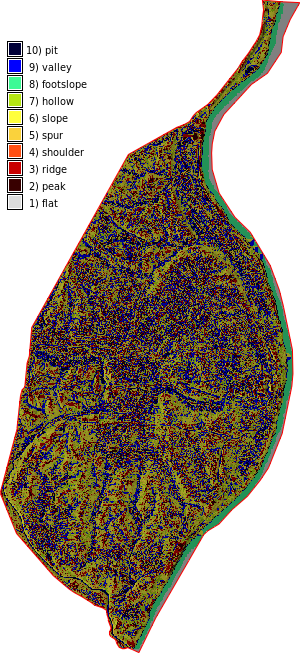

In [199]:
gs.run_command("r.geomorphon", elevation="cop-dem-glo-30", search=15, flat=0.1, forms="geomorphon", overwrite=True)
map = gj.Map(width=300)
map.d_shade(shade="relief", color="geomorphon")
map.d_vect(map="stl_boundary", color="red", fill_color="none")
map.d_legend(raster="geomorphon", at="95,65,2,5", flags="")
map.show()

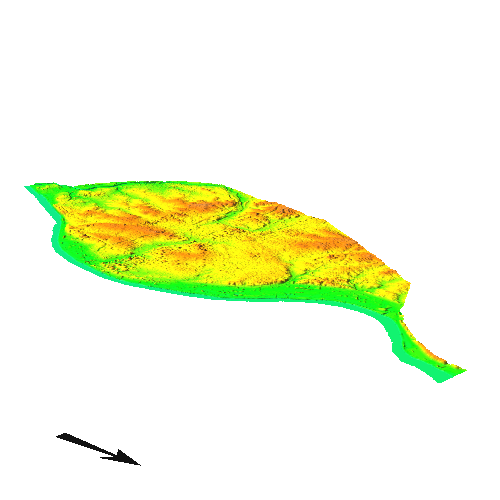

In [65]:
map3d = gj.Map3D(width=500, height=500)
map3d.render(
    elevation_map="cop-dem-glo-30",
    color_map="cop-dem-glo-30",
    zexag=3, 
    perspective=15, 
    height=8000, 
    resolution_fine=1,
    arrow_position=[100,50],
)
map3d.show()

In [120]:
gs.run_command("r.mask", flags="r")

In [207]:
# gs.run_command("g.extension", extension="r.slope.direction", operation="add", overwrite=True)
gs.run_command("v.to.rast", input="stl_streets", output="stl_streets", use="dir", type="line", overwrite=True) 
gs.run_command("r.slope.direction",
    elevation='"cop-dem-glo-30"', # Report Bug - String is not being parsed correctly
    direction="stl_streets",
    slope_measure="degree",  # The angle described by the total elevation difference devided by the total distance over the user given number of steps along the direction map
    output="streets_slope_dir",
    overwrite=True)
gs.run_command("r.colors", map="streets_slope_dir", color="gyr", flags="e")

In [208]:
gs.run_command("r.info", map="streets_slope_dir")

 +----------------------------------------------------------------------------+
 | Map:      streets_slope_dir              Date: Sun Sep  8 01:03:23 2024    |
 | Mapset:   PERMANENT                      Login of Creator: coreywhite      |
 | Project:  foss4g2024                                                       |
 | DataBase: /tmp/tmpod5n7w14                                                 |
 | Title:                                                                     |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 0               |
 |   Data Type:    DCELL                Semantic label: (none)                |
 |   Rows:         908                                                        |
 |   Columns:      417                  

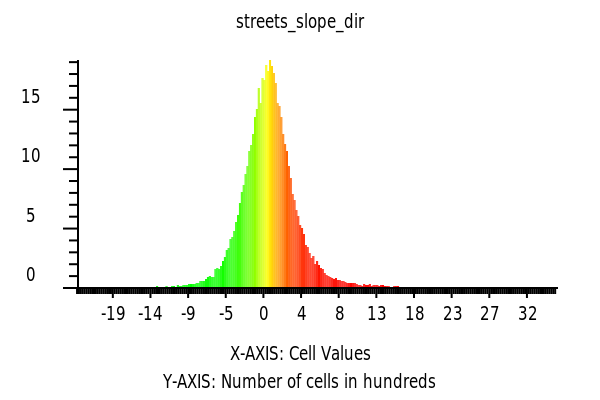

In [209]:
hist = gj.Map(width=600, height=400)
hist.d_histogram(map="streets_slope_dir")
hist.show()


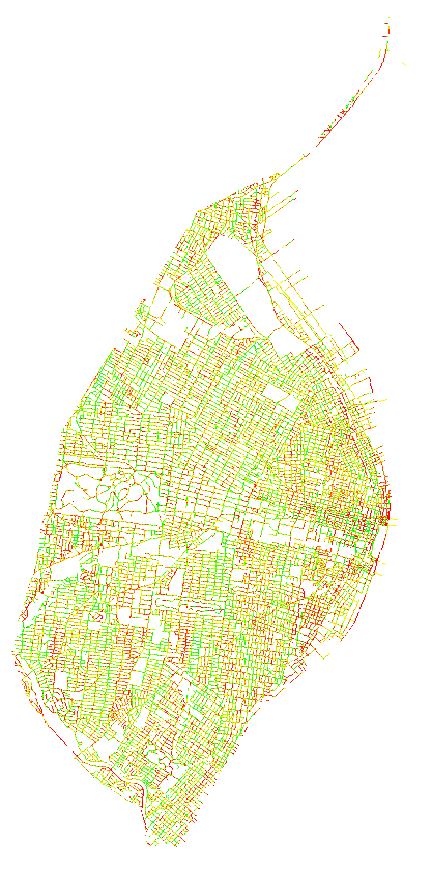
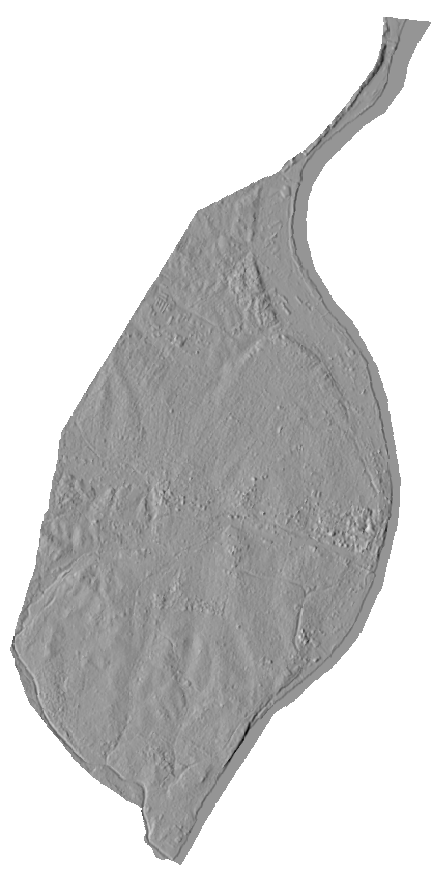

In [210]:
gs.run_command("r.mask", vector="stl_boundary")
map = gj.InteractiveMap(width=500, map_backend="folium")
map.add_raster("streets_slope_dir", opacity=0.5)
map.add_raster("relief", opacity=0.75)
map.add_vector("stl_boundary", fill_color="none", line_color="red")
map.show()

## Let's practice!

1. Set the computational region to the `cop-dem-glo-30` raster map.

# Add your python code here

In [237]:
!r.info streets_slope_dir --json

{
  "module": "r.info",
  "id": "r.info_1804289383",
  "inputs":[
     {"param": "map", "value": "streets_slope_dir"},
     {"param": "format", "value": "plain"}
   ]}


In [242]:
process = gs.parse_command("r.info", map="streets_slope_dir", help=True)
process

Outputs basic information about a raster map.

Usage:
 r.info [-grseh] map=name format=name [--help] [--verbose] [--quiet]
   [--ui]

Flags:
  -g   Print raster array information in shell script style
  -r   Print range in shell script style
  -s   Print stats in shell script style
  -e   Print extended metadata information in shell script style
  -h   Print raster history instead of info

Parameters:
     map   Name of raster map
  format   Output format
           options: plain,json
           default: plain

ERROR: r.info: Sorry, <help> is not a valid parameter


CalledModuleError: Module run `r.info map=streets_slope_dir help=True` ended with an error.
The subprocess ended with a non-zero return code: 1. See errors above the traceback or in the error output.